In [ ]:
!apt-get update -qq
!apt-get install -y unzip
!unzip recognize-digits.zip


W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
unzip is already the newest version (6.0-26ubuntu3.2).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.
Archive:  recognize-digits.zip
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

train_df = pd.read_csv("train.csv")
test_df  = pd.read_csv("test.csv")

print(train_df.shape, test_df.shape)
train_df.head()


(42000, 785) (28000, 784)


,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


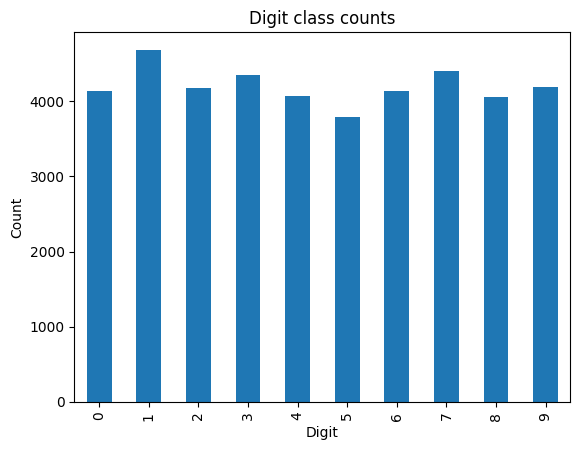

In [ ]:
y = train_df["label"].values
X = train_df.drop(columns=["label"]).values

plt.figure()
pd.Series(y).value_counts().sort_index().plot(kind="bar")
plt.title("Digit class counts")
plt.xlabel("Digit")
plt.ylabel("Count")
plt.show()


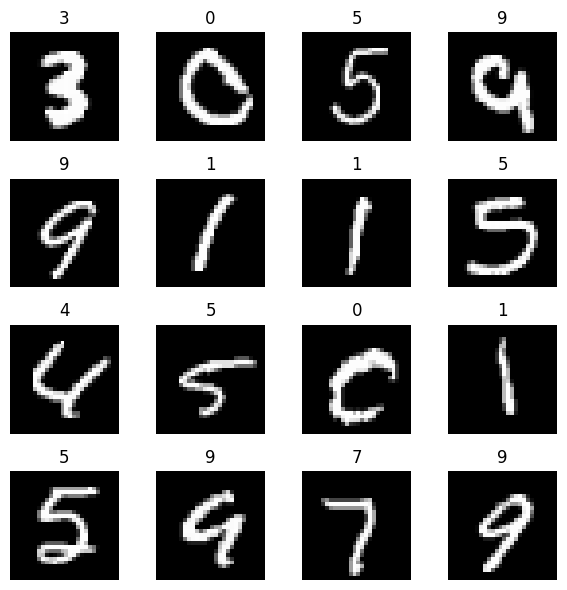

In [ ]:
def show_samples(X, y, n=16):
    plt.figure(figsize=(6,6))
    idx = np.random.choice(len(X), n, replace=False)
    for i, k in enumerate(idx):
        img = X[k].reshape(28,28)
        plt.subplot(4,4,i+1)
        plt.imshow(img, cmap="gray")
        plt.title(str(y[k]))
        plt.axis("off")
    plt.tight_layout()
    plt.show()

show_samples(X, y, n=16)


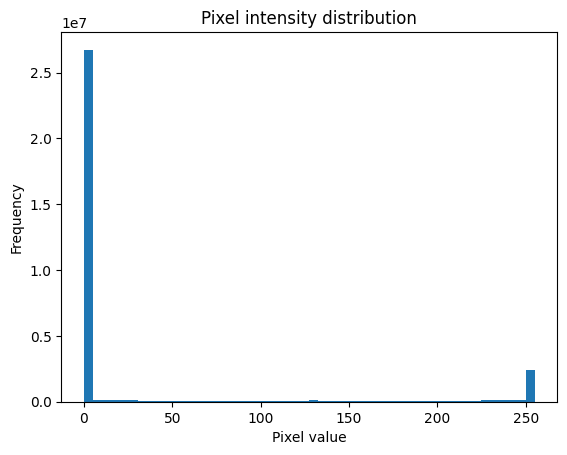

In [ ]:
plt.figure()
plt.hist(X.flatten(), bins=50)
plt.title("Pixel intensity distribution")
plt.xlabel("Pixel value")
plt.ylabel("Frequency")
plt.show()


In [ ]:
X = X.astype("float32") / 255.0
X_test = test_df.values.astype("float32") / 255.0

X = X.reshape(-1, 28, 28, 1)
X_test = X_test.reshape(-1, 28, 28, 1)

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.15, random_state=42, stratify=y
)

print(X_train.shape, X_val.shape)


(35700, 28, 28, 1) (6300, 28, 28, 1)


In [ ]:
model = keras.Sequential([
    layers.Input(shape=(28,28,1)),
    layers.Conv2D(32, 3, activation="relu"),
    layers.BatchNormalization(),
    layers.Conv2D(32, 3, activation="relu"),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),

    layers.Conv2D(64, 3, activation="relu"),
    layers.BatchNormalization(),
    layers.Conv2D(64, 3, activation="relu"),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),

    layers.Flatten(),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(10, activation="softmax"),
])

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 26, 26, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 24, 24, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 12, 12, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 12, 12, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 10, 10, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 10, 10, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 8, 8, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 197,866 (772.91 KB)

 Trainable params: 197,674 (772.16 KB)

 Non-trainable params: 192 (768.00 B)

Epoch 1/15
279/279 ━━━━━━━━━━━━━━━━━━━━ 100s 338ms/step - accuracy: 0.7293 - loss: 0.8861 - val_accuracy: 0.2176 - val_loss: 2.7710 - learning_rate: 0.0010
Epoch 2/15
279/279 ━━━━━━━━━━━━━━━━━━━━ 140s 332ms/step - accuracy: 0.9666 - loss: 0.1094 - val_accuracy: 0.9414 - val_loss: 0.1978 - learning_rate: 0.0010
Epoch 3/15
279/279 ━━━━━━━━━━━━━━━━━━━━ 140s 326ms/step - accuracy: 0.9762 - loss: 0.0793 - val_accuracy: 0.9887 - val_loss: 0.0429 - learning_rate: 0.0010
Epoch 4/15
279/279 ━━━━━━━━━━━━━━━━━━━━ 94s 336ms/step - accuracy: 0.9810 - loss: 0.0635 - val_accuracy: 0.9879 - val_loss: 0.0390 - learning_rate: 0.0010
Epoch 5/15
279/279 ━━━━━━━━━━━━━━━━━━━━ 95s 341ms/step - accuracy: 0.9839 - loss: 0.0520 - val_accuracy: 0.9908 - val_loss: 0.0350 - learning_rate: 0.0010
Epoch 6/15
279/279 ━━━━━━━━━━━━━━━━━━━━ 138s 327ms/step - accuracy: 0.9861 - loss: 0.0408 - val_accuracy: 0.9914 - val_loss: 0.0325 - learning_rate: 0.0010
Epoch 7/15
279/279 ━━━━━━━━━━━━━━━━━━━━ 93s 333ms/step - accuracy:

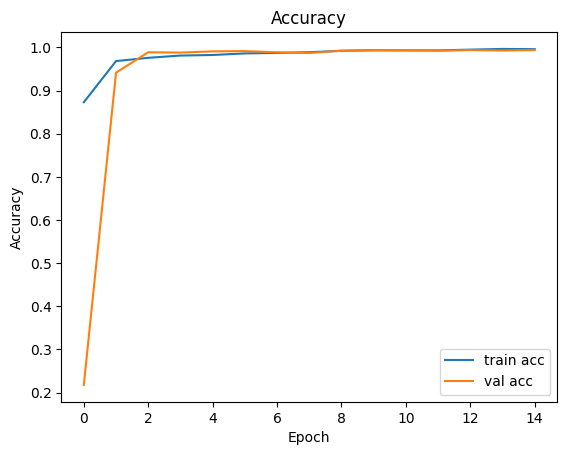

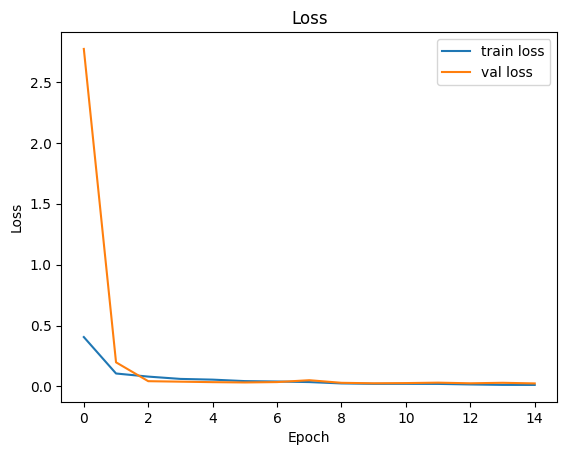

In [ ]:
callbacks = [
    keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True),
    keras.callbacks.ReduceLROnPlateau(patience=2, factor=0.5)
]

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=15,
    batch_size=128,
    callbacks=callbacks,
    verbose=1
)

# Plot accuracy and loss
plt.figure()
plt.plot(history.history["accuracy"], label="train acc")
plt.plot(history.history["val_accuracy"], label="val acc")
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

plt.figure()
plt.plot(history.history["loss"], label="train loss")
plt.plot(history.history["val_loss"], label="val loss")
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()


197/197 ━━━━━━━━━━━━━━━━━━━━ 10s 50ms/step


<Figure size 700x700 with 0 Axes>

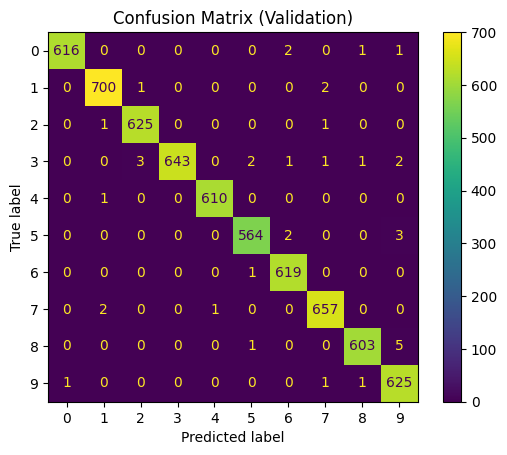

In [ ]:
val_probs = model.predict(X_val)
val_pred = np.argmax(val_probs, axis=1)

cm = confusion_matrix(y_val, val_pred, labels=list(range(10)))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(range(10)))

plt.figure(figsize=(7,7))
disp.plot(values_format="d")
plt.title("Confusion Matrix (Validation)")
plt.show()


In [ ]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import tensorflow as tf
from tensorflow.keras import layers, Sequential


In [ ]:
# Load
train_df = pd.read_csv("train.csv")
test_df  = pd.read_csv("test.csv")

y = train_df["label"].values
X = train_df.drop(columns=["label"]).values.astype("float32") / 255.0
X_test = test_df.values.astype("float32") / 255.0


In [ ]:
# Reshape to images
X = X.reshape(-1,28,28,1)
X_test = X_test.reshape(-1,28,28,1)

In [ ]:
# Split (keep validation for confusion matrix)
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.1, random_state=42, stratify=y
)

In [ ]:
# ---- Data Augmentation (helps generalization + Kaggle score)
augment = tf.keras.Sequential([
    layers.RandomRotation(0.06),          # small rotations
    layers.RandomTranslation(0.08, 0.08), # small shifts
    layers.RandomZoom(0.08),
])

In [ ]:
# ---- Better CNN (BatchNorm stabilizes training)
model = Sequential([
    layers.Input((28,28,1)),
    layers.Lambda(lambda x: augment(x, training=True)),  # apply augmentation only during training

    layers.Conv2D(32, 3, padding="same", activation="relu"),
    layers.BatchNormalization(),
    layers.Conv2D(32, 3, padding="same", activation="relu"),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),

    layers.Conv2D(64, 3, padding="same", activation="relu"),
    layers.BatchNormalization(),
    layers.Conv2D(64, 3, padding="same", activation="relu"),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    layers.Dropout(0.30),

    layers.Conv2D(128, 3, padding="same", activation="relu"),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    layers.Dropout(0.35),

    layers.Flatten(),
    layers.Dense(256, activation="relu"),
    layers.Dropout(0.40),
    layers.Dense(10, activation="softmax")
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)


In [ ]:
# ---- Callbacks: reduce LR when stuck + stop when best
cbs = [
    tf.keras.callbacks.ReduceLROnPlateau(monitor="val_accuracy", factor=0.5, patience=2, verbose=1),
    tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=5, restore_best_weights=True)
]

hist = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=30,             # allow it to improve; early stopping will stop automatically
    batch_size=128,
    callbacks=cbs,
    verbose=1
)

Epoch 1/30
296/296 ━━━━━━━━━━━━━━━━━━━━ 221s 707ms/step - accuracy: 0.6012 - loss: 1.3623 - val_accuracy: 0.2676 - val_loss: 2.7421 - learning_rate: 0.0010
Epoch 2/30
296/296 ━━━━━━━━━━━━━━━━━━━━ 214s 723ms/step - accuracy: 0.9361 - loss: 0.2079 - val_accuracy: 0.9343 - val_loss: 0.2133 - learning_rate: 0.0010
Epoch 3/30
296/296 ━━━━━━━━━━━━━━━━━━━━ 257s 707ms/step - accuracy: 0.9562 - loss: 0.1492 - val_accuracy: 0.9798 - val_loss: 0.0697 - learning_rate: 0.0010
Epoch 4/30
296/296 ━━━━━━━━━━━━━━━━━━━━ 261s 703ms/step - accuracy: 0.9655 - loss: 0.1148 - val_accuracy: 0.9790 - val_loss: 0.0671 - learning_rate: 0.0010
Epoch 5/30
296/296 ━━━━━━━━━━━━━━━━━━━━ 208s 704ms/step - accuracy: 0.9677 - loss: 0.1057 - val_accuracy: 0.9819 - val_loss: 0.0592 - learning_rate: 0.0010
Epoch 6/30
296/296 ━━━━━━━━━━━━━━━━━━━━ 208s 702ms/step - accuracy: 0.9735 - loss: 0.0909 - val_accuracy: 0.9819 - val_loss: 0.0632 - learning_rate: 0.0010
Epoch 7/30
296/296 ━━━━━━━━━━━━━━━━━━━━ 263s 707ms/step - accura

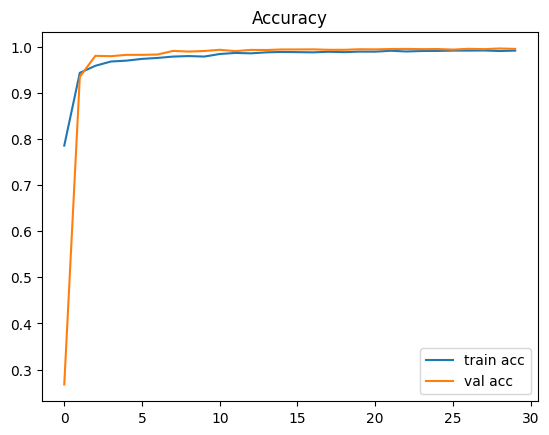

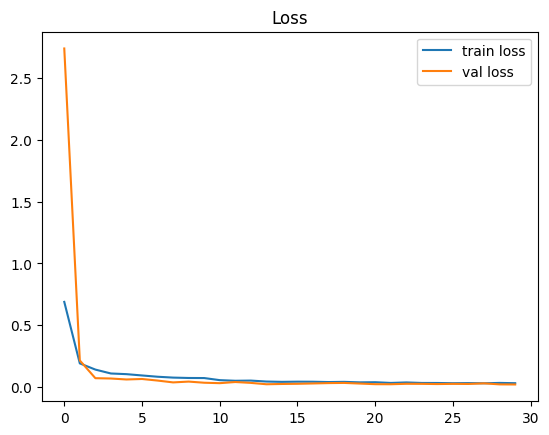

132/132 ━━━━━━━━━━━━━━━━━━━━ 16s 109ms/step


<Figure size 700x700 with 0 Axes>

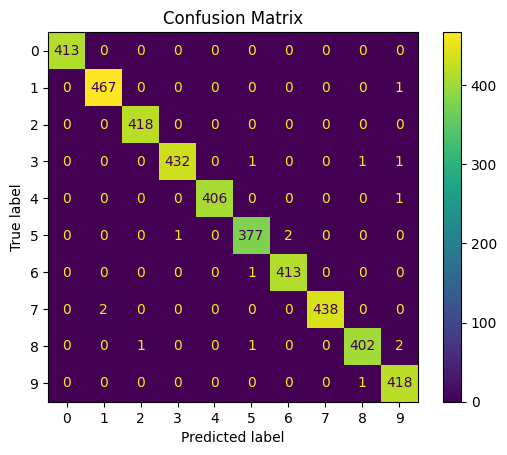

In [ ]:
# ---- Training curves (quick charts)
plt.figure()
plt.plot(hist.history["accuracy"], label="train acc")
plt.plot(hist.history["val_accuracy"], label="val acc")
plt.legend(); plt.title("Accuracy"); plt.show()

plt.figure()
plt.plot(hist.history["loss"], label="train loss")
plt.plot(hist.history["val_loss"], label="val loss")
plt.legend(); plt.title("Loss"); plt.show()

# ---- (7) Confusion matrix (your step)
val_pred = np.argmax(model.predict(X_val), axis=1)
cm = confusion_matrix(y_val, val_pred)

plt.figure(figsize=(7,7))
ConfusionMatrixDisplay(cm).plot(values_format="d")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
# ---- Kaggle submission
test_pred = np.argmax(model.predict(X_test), axis=1)
sub = pd.DataFrame({"ImageId": np.arange(1, len(test_pred)+1), "Label": test_pred})
sub.to_csv("submission.csv", index=False)
sub.head()

875/875 ━━━━━━━━━━━━━━━━━━━━ 41s 46ms/step


,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,0
4,5,3


In [ ]:
# After model.fit(...)
print("Final TRAIN accuracy :", hist.history["accuracy"][-1])
print("Final VAL accuracy   :", hist.history["val_accuracy"][-1])


Final TRAIN accuracy : 0.9910582304000854
Final VAL accuracy   : 0.9947618842124939


In [ ]:
from google.colab import files
files.download("submission.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
model.save("digit_cnn.h5")
print("Model saved as digit_cnn.h5")


Model saved as digit_cnn.h5


In [ ]:
from google.colab import files
files.download("digit_cnn.h5")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
model.save("/content/drive/MyDrive/digit_project/digit_cnn.h5")
pd.DataFrame(hist.history).to_csv("/content/drive/MyDrive/digit_project/training_history.csv", index=False)
sub.to_csv("/content/drive/MyDrive/digit_project/submission.csv", index=False)